In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os

2025-08-20 14:38:37.744050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755700718.099248      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755700718.200205      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_set_path = "/kaggle/input/new-paddy-doctor-paddy-disease-classification/paddy-disease-classification"
data_set_train_path = os.path.join(data_set_path, "train_images")
print(data_set_train_path)
data_set_test_path = os.path.join(data_set_path, "test_images")

/kaggle/input/new-paddy-doctor-paddy-disease-classification/paddy-disease-classification/train_images


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
TRAIN_DATA_SIZE = 0.8
TEST_DATA_SIZE = 1 - TRAIN_DATA_SIZE
VALIDATION_DATA_SIZE = 0.1

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 19131 files belonging to 10 classes.


I0000 00:00:1755700762.634791      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755700762.635666      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Data Visualization

In [5]:
class_names = train_dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [6]:
def calculate_class_counts(dataset,folder_path):
  class_names = dataset.class_names
  class_counts = {}
  for class_name in class_names:
    class_dir = os.path.join(folder_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))
  return class_counts


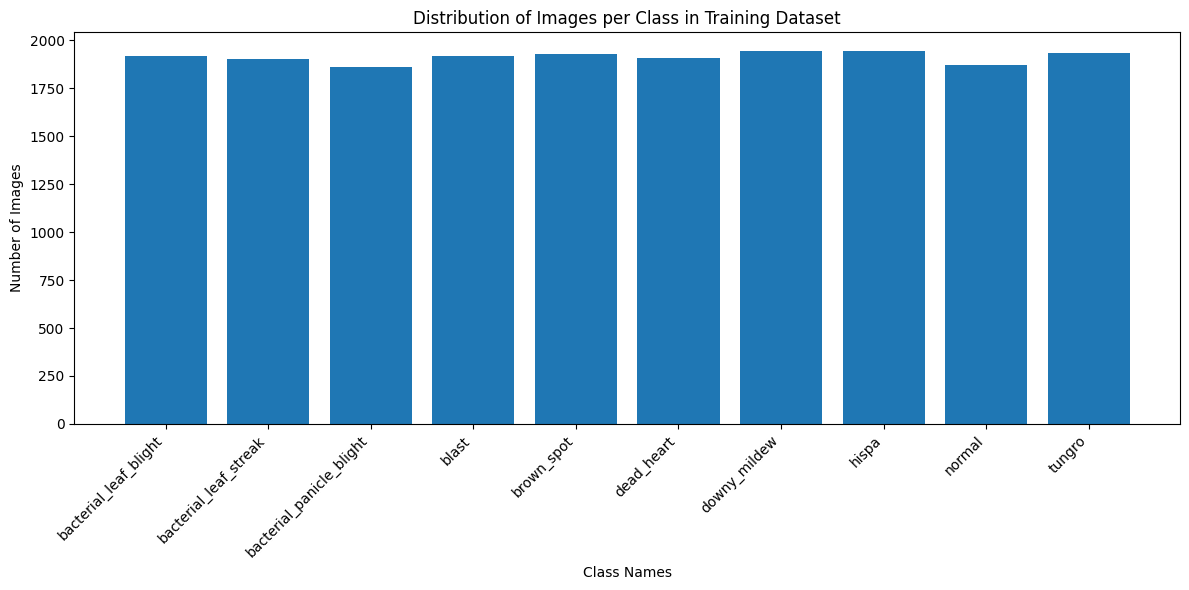

In [7]:
train_dataset_class_counts = calculate_class_counts(train_dataset,data_set_train_path)
plt.figure(figsize=(12, 6))
plt.bar(train_dataset_class_counts.keys(), train_dataset_class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class in Training Dataset")
plt.tight_layout()
plt.show()

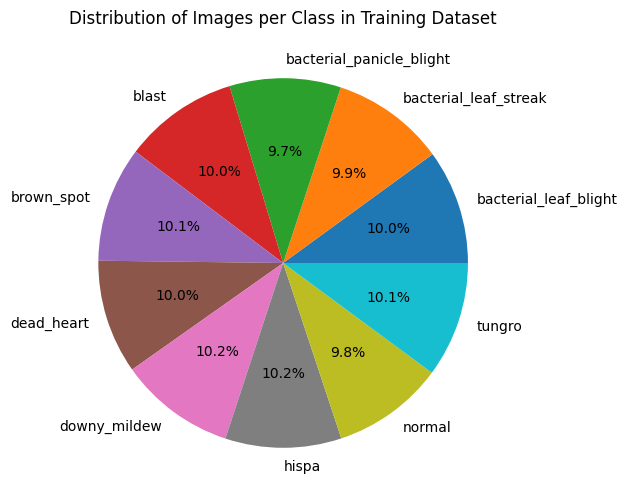

In [8]:
plt.figure(figsize=(12, 6))
plt.pie(train_dataset_class_counts.values(), labels=train_dataset_class_counts.keys(), autopct='%1.1f%%')
plt.title("Distribution of Images per Class in Training Dataset")
plt.show()

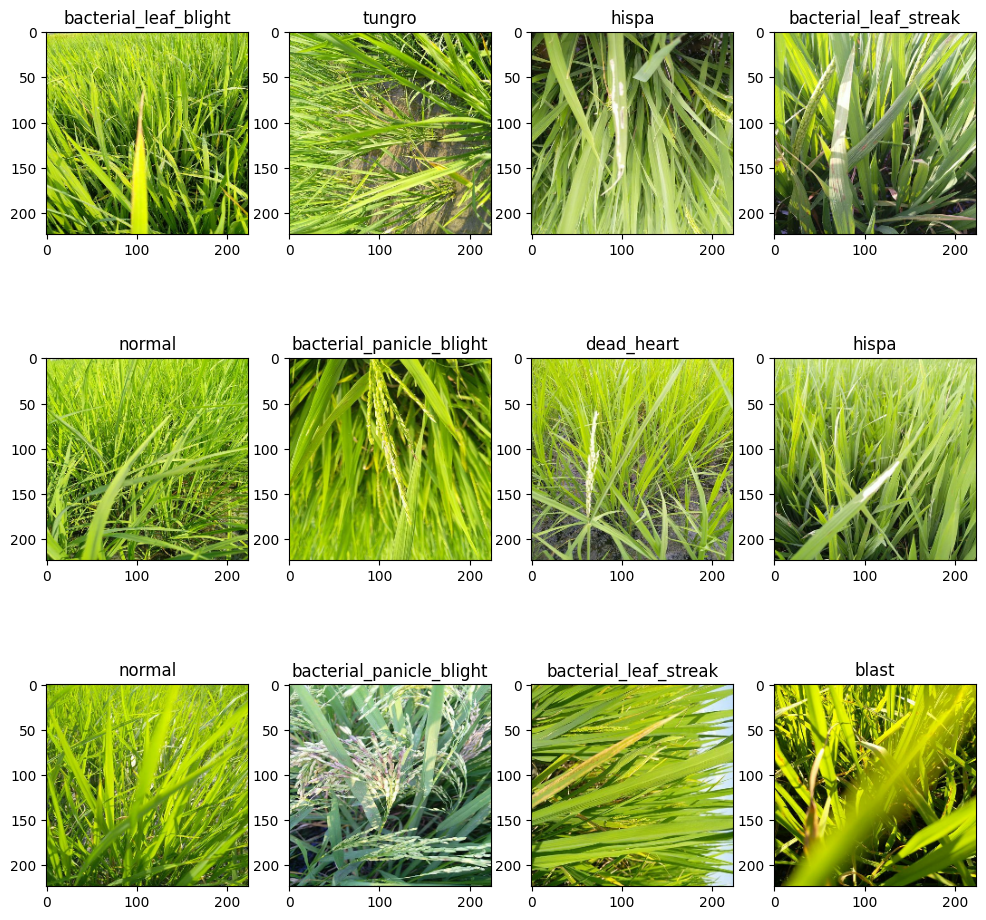

In [9]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

## visiualize pre splitted test data

In [10]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_test_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.


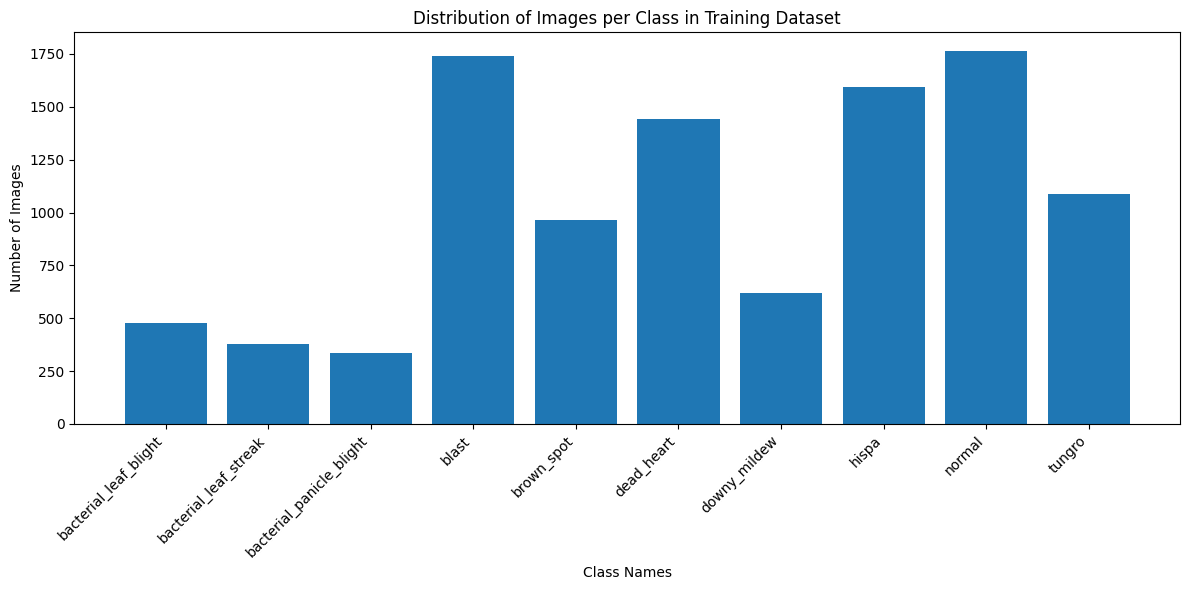

In [11]:
test_data_class_count = calculate_class_counts(test_data,data_set_test_path)
plt.figure(figsize=(12, 6))
plt.bar(test_data_class_count.keys(), test_data_class_count.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class in Training Dataset")
plt.tight_layout()
plt.show()

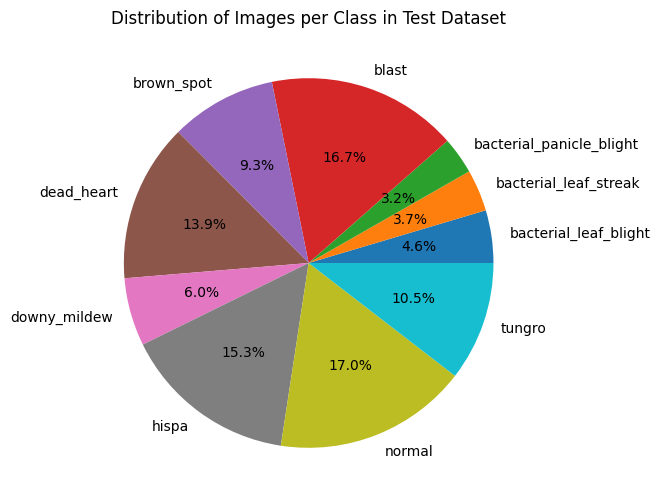

In [12]:
plt.figure(figsize=(12, 6))
plt.pie(test_data_class_count.values(), labels=test_data_class_count.keys(), autopct='%1.1f%%')
plt.title(f"Distribution of Images per Class in Test Dataset")
plt.show()

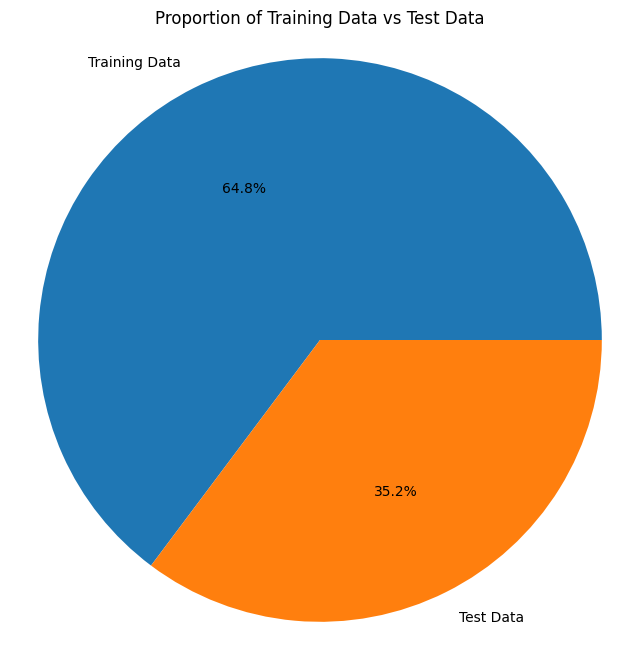

In [13]:
total_train_images = sum(train_dataset_class_counts.values())
total_test_images = sum(test_data_class_count.values())

labels = ['Training Data', 'Test Data']
sizes = [total_train_images, total_test_images]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)
plt.title("Proportion of Training Data vs Test Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# check pre defined test data are same or not

In [14]:
def extract_file_names_from_dataset(data_test_classes,data_set_path):
  train_data_names = []
  for class_name in data_test_classes:
      train_data_names.extend(os.listdir(os.path.join(data_set_path,class_name)))
  return set(train_data_names)

is_smae =  extract_file_names_from_dataset(train_dataset.class_names,data_set_train_path).intersection(extract_file_names_from_dataset(test_data.class_names,data_set_test_path))
if is_smae:
  print("test data and train data are same")
else:
  print("test data and train data are not same")

test data and train data are same


In [15]:
len(train_dataset)

598

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(train_dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,validation_ds,test_ds

In [18]:
train_ds,validation_ds,test_ds = get_dataset_partitions_tf(train_dataset)

In [19]:
len(train_ds),len(validation_ds),len(test_ds)

(478, 59, 61)

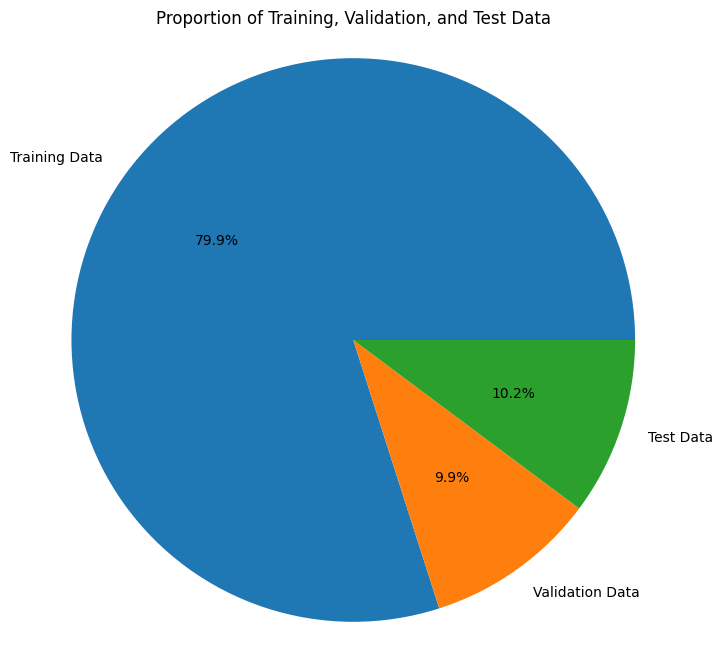

In [20]:
labels = ['Training Data', 'Validation Data', 'Test Data']
sizes = [len(train_ds), len(validation_ds), len(test_ds)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)
plt.title("Proportion of Training, Validation, and Test Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Datasets optimization

In [21]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Image preprocessing

In [24]:
resize_and_scale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Model Build

In [26]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_scale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu' ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')

])

In [27]:
model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 26, 26, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 24, 24, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 10, 10, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 5, 5, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 3, 3, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 1, 1, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,914 (671.54 KB)

 Trainable params: 171,914 (671.54 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Training

In [30]:
history = model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=validation_ds,verbose=1,epochs=EPOCHS)

Epoch 1/50


I0000 00:00:1755701792.205635     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


478/478 ━━━━━━━━━━━━━━━━━━━━ 108s 89ms/step - accuracy: 0.1488 - loss: 2.2302 - val_accuracy: 0.2701 - val_loss: 1.9683
Epoch 2/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 62s 87ms/step - accuracy: 0.3102 - loss: 1.8866 - val_accuracy: 0.2855 - val_loss: 1.9503
Epoch 3/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 62s 87ms/step - accuracy: 0.3818 - loss: 1.7276 - val_accuracy: 0.3681 - val_loss: 1.7404
Epoch 4/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 63s 87ms/step - accuracy: 0.4467 - loss: 1.5781 - val_accuracy: 0.4831 - val_loss: 1.4833
Epoch 5/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 62s 87ms/step - accuracy: 0.4958 - loss: 1.4680 - val_accuracy: 0.4989 - val_loss: 1.4426
Epoch 6/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 62s 86ms/step - accuracy: 0.5235 - loss: 1.3710 - val_accuracy: 0.4131 - val_loss: 1.7716
Epoch 7/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 61s 86ms/step - accuracy: 0.5702 - loss: 1.2396 - val_accuracy: 0.5270 - val_loss: 1.3281
Epoch 8/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 62s 86ms/step - accuracy: 0.5902 - loss: 1.1837 - val_accura

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

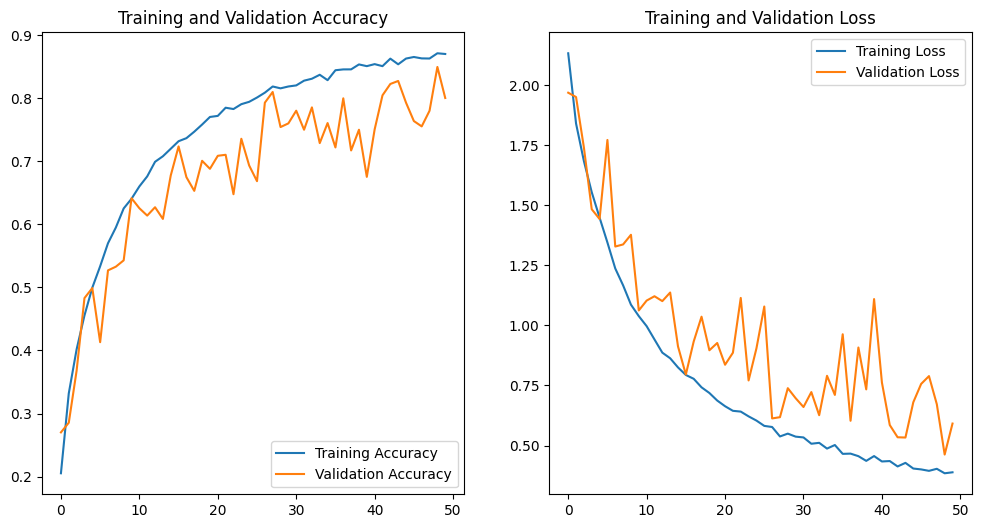

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: bacterial_leaf_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
predicted label: bacterial_leaf_blight


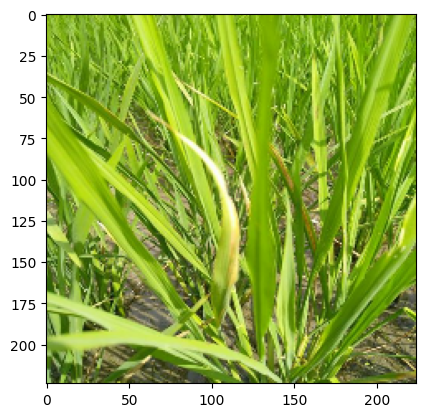

In [36]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [2]:
def predict(model,image_array):
  img_array = tf.expand_dims(image_array, 0)
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

In [1]:
plt.figure(figsize=(15, 15))
for images,labels in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

NameError: name 'plt' is not defined

# Model Save

In [55]:
os.mkdir("models")

FileExistsError: [Errno 17] File exists: 'models'

In [58]:
model_version =max([int(i) for i in os.listdir("/kaggle/working/models")+[0]])+1

In [1]:
model.save(f"/kaggle/working/models/{model_version}")

NameError: name 'model' is not defined